## 곰 분류 모델

### 모델 학습에 사용할 이미지 다운 및 파일 오류 검증

In [6]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [7]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [8]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [9]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [10]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

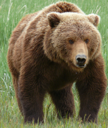

In [11]:
im = Image.open(dest)
im.to_thumb(128,128)

In [12]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [13]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [14]:
fns = get_image_files(path)
fns

(#425) [Path('bears/black/07d555e8-c8a0-4ea9-9e34-d74afe16a87c.jpg'),Path('bears/black/09131446-d286-4596-bd02-146093060d6e.jpg'),Path('bears/black/09d6a700-09cf-4386-9738-749e88b1d921.jpg'),Path('bears/black/0d81fc2f-ccdd-4996-97b6-79f1df86c15c.jpg'),Path('bears/black/108eb9c3-ac96-4b5c-ac33-789855357b69.jpg'),Path('bears/black/12952a67-7526-4361-8661-a1877bbc0ee9.jpg'),Path('bears/black/132f5efc-86d3-459a-8fa8-cf1e494e20ee.jpg'),Path('bears/black/1381a456-5179-4548-8803-1c85b6c84579.jpg'),Path('bears/black/1404875e-05b3-44a9-9c75-0eff52c0bacb.jpg'),Path('bears/black/1416462b-3175-4b91-a6eb-e74819bed6e8.jpg')...]

In [17]:
failed = verify_images(fns) #파일의 오류 여부 검사
failed

(#4) [Path('bears/black/845e42f9-ab85-4229-9a1f-6df02fe0d799.jpg'),Path('bears/teddy/22834e9d-835a-4fba-8b75-1c4751a1c5fd.jpg'),Path('bears/teddy/655ad758-87f5-4916-8b1c-bde4afd75497.jpg'),Path('bears/teddy/da734b9a-7240-42fe-9d55-f893217bc33b.jpg')]

In [18]:
failed.map(Path.unlink); #오류가 발생한 모든 파일(요소) 삭제

### 다운로드한 데이터를 DataLoaders 객체로 만들기

In [19]:
class DataLoaders(GetAttr): #객체를 학습용과 검증용으로 나누어 저장
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [21]:
bears = DataBlock( #데이터블록 API를 사용해 다운로드한 데이터셋을 DataLoaders로 변환
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label, #파일이 저장된 폴더명 반환
    item_tfms=Resize(128))

In [22]:
dls = bears.dataloaders(path)

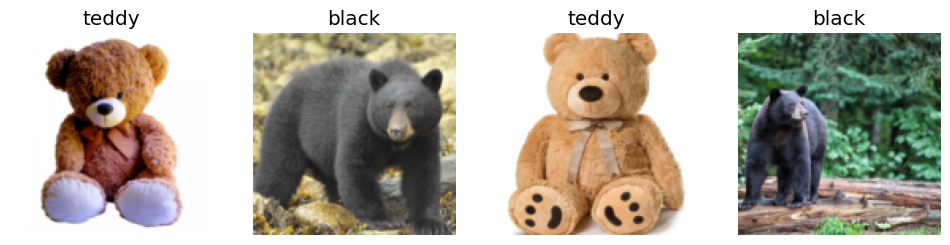

In [23]:
dls.valid.show_batch(max_n=4, nrows=1)

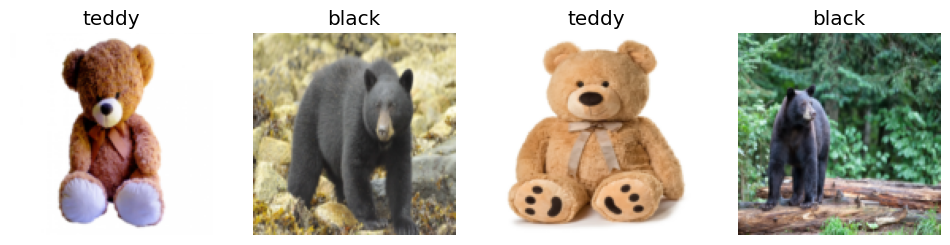

In [24]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

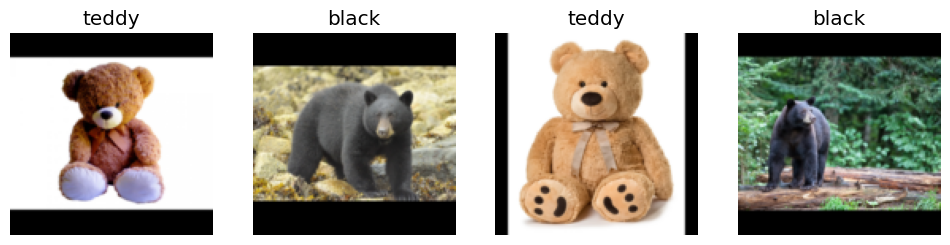

In [25]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

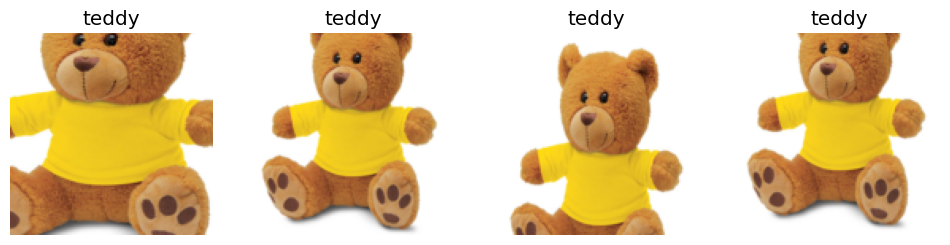

In [26]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

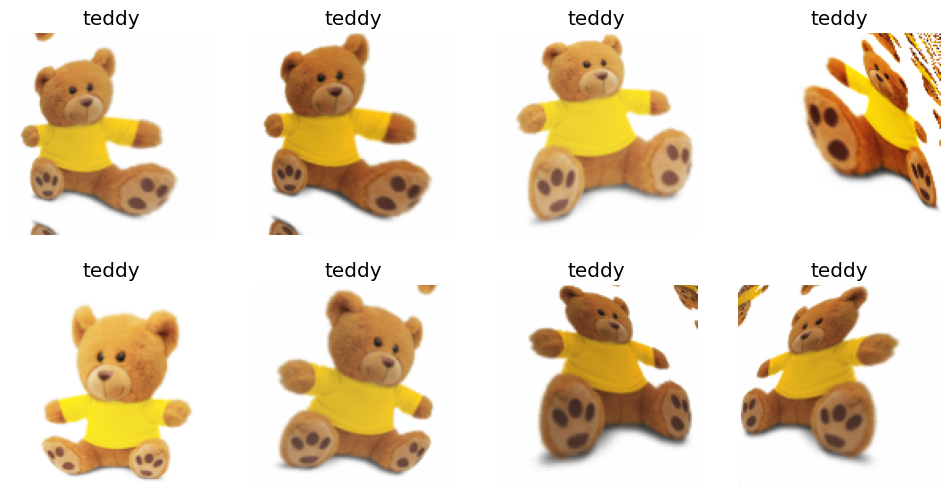

In [28]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2)) #데이터 증강
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### 모델 훈련과 훈련된 모델을 이용한 데이터 정리

In [29]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [30]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

C:\Users\user\.conda\envs\geopandas\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\.conda\envs\geopandas\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

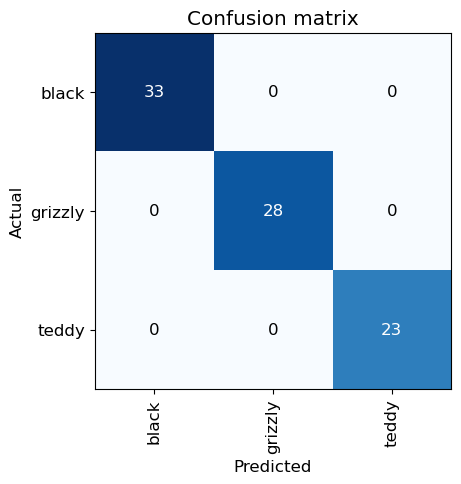

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix() #오차행렬을 활용하여 실수 확인

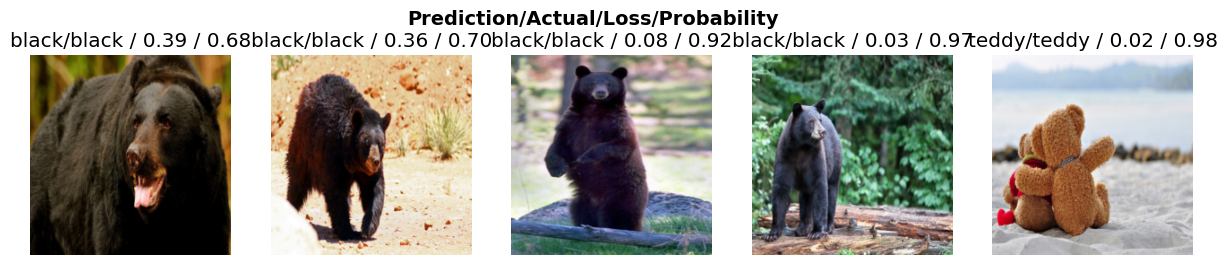

In [32]:
interp.plot_top_losses(5, nrows=1)

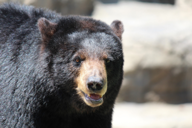

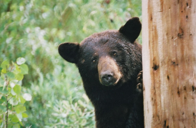

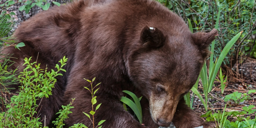

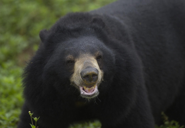

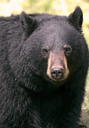

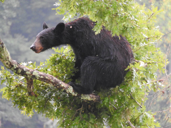

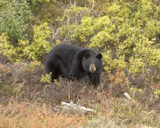

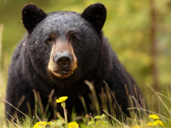

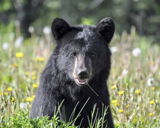

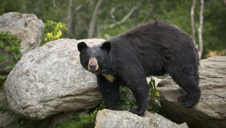

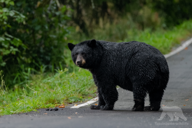

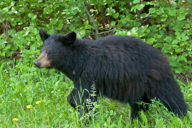

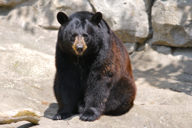

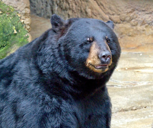

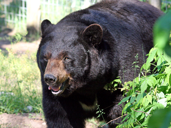

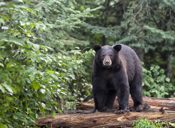

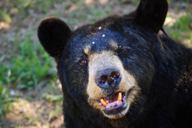

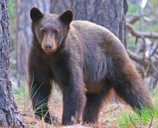

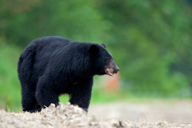

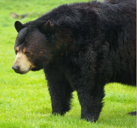

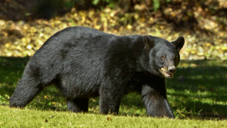

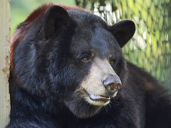

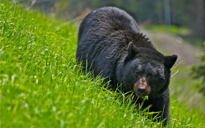

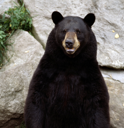

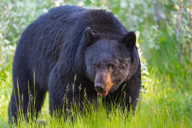

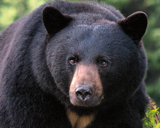

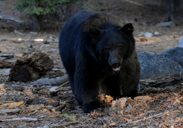

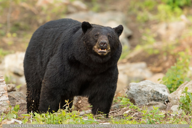

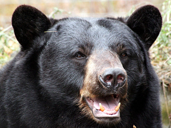

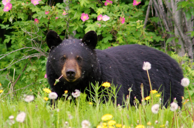

In [33]:
cleaner = ImageClassifierCleaner(learn) #선택한 삭제 또는 변경 목록의 색인번호 반환
cleaner

In [34]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink() #삭제를 선택한 모든 이미지를 실제로 삭제

In [35]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat) #레이블의 변경을 선택한 모든 이미지를 알맞은 범주의 디렉터리로 옮기기

### 모델을 온라인 어플리케이션으로 전환하기

In [36]:
learn.export()

In [37]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [38]:
learn_inf = load_learner(path/'export.pkl')

In [39]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([4.5028e-08, 1.0000e+00, 3.5784e-08]))

In [40]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [41]:
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [42]:
img = PILImage.create(btn_upload.data[-1])

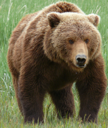

Output()

In [43]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [44]:
pred,pred_idx,probs = learn_inf.predict(img)

In [45]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [46]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [47]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [48]:
btn_upload = widgets.FileUpload()

In [49]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [50]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     ---------------------------------------- 5.5/5.5 MB 127.1 kB/s eta 0:00:00
     -------------------------------------- 132.1/132.1 kB 8.1 MB/s eta 0:00:00
     -------------------------------------- 101.4/101.4 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter_client 7.4.7
    Uninstalling jupyter_client-7.4.7:
      Successfully uninstalled jupyter_client-7.4.7


Enabling: voila
- Writing config: C:\Users\user\.conda\envs\geopandas\etc\jupyter
    - Validating...
      voila 0.4.0 ok
